# Imports

In [1]:
# Imports
# Standard Imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import torch
import os

# Ch 2 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from sklearn.metrics import accuracy_score

# Ch 3 Imports
import torchvision
from torchvision import transforms

# Now you can import your file just like any other library
import sys
sys.path.append('../Inside-Deep-Learning/')

from idlmam import *


In [2]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   B = 32
   epochs = 20
   num_workers_data_loaders = 2
elif torch.xpu.is_available():
   device = torch.device("xpu")
   B = 32
   epochs = 20
   num_workers_data_loaders = 2
else:
   device = torch.device("cpu")
   B = 1
   epochs = 5
   num_workers_data_loaders = 1

print(device)

xpu


# 1\.  Create a new version of the MNIST dataset that does not contain the numbers 9 and 5, and train one of the autoencoders on this dataset. Then run the autoencoder on the test dataset, and record the average error (MSE) for each of the 10 classes. Do you see any patterns in the results, and can the autoencoder identify 9 and 5 as outliers?

## Get MNIST data

In [3]:
train_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)

In [4]:
D = 28*28
n = 2
C = 1
classes = 10

In [5]:
len(train_data), len(train_data[0]), 

(60000, 2)

## Create new Dataset class to handle dropping rows

In [8]:
class CustomMNISTDataset(Dataset):
    
    def __init__(self, dataset, labels_to_drop=[]):
        self.data = []
        self.labels = []
        
        idx = 0
        for X, y in dataset:
            if y not in labels_to_drop:
                self.data.append(X)
                self.labels.append(y)
                idx += 1
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return  self.data[idx], self.labels[idx]

In [9]:
class AutoEncodeDataset(Dataset): 
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to reuse other code"""

    def __init__(self, dataset): 
        self.dataset = dataset

    def __len__(self): 
        return len(self.dataset)

    def __getitem__(self, idx): 
        x, y = self.dataset.__getitem__(idx) 
        return x, x

In [11]:
train_data_59_xy = CustomMNISTDataset(train_data, labels_to_drop=[5,9])
train_data_59_xx = AutoEncodeDataset(train_data_59_xy)
test_data_xx = AutoEncodeDataset(test_data)


train_loader = DataLoader(train_data_59_xx, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=256)

## Create model

In [62]:
def getLayer(in_size, out_size): 
    """ 
    in_size: how many neurons/features are coming into this layer 
    out_size: how many neurons/outputs this hidden layer should produce 
    """ 
    return nn.Sequential(
        nn.Linear(in_size, out_size), 
        nn.BatchNorm1d(out_size), 
        nn.ReLU())

In [22]:
auto_encoder = nn.Sequential(
    nn.Flatten(), 
    getLayer(D, D//2),
    getLayer(D//2, D//3), 
    getLayer(D//3, D//4), 
    nn.Linear(D//4, n),
)

auto_decoder = nn.Sequential(
    getLayer(n, D//4),
    getLayer(D//4, D//3), 
    getLayer(D//3, D//2),

    nn.Linear(D//2, D), 
    View(-1, 1, 28, 28)
)
auto_encode_decode = nn.Sequential(
    auto_encoder, 
    auto_decoder 
)

In [23]:
loss = nn.MSELoss()

train_network(auto_encode_decode, loss, train_loader, 
 test_loader=test_loader, epochs=10, device=device)

Epoch: 100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


,epoch,total time,train loss,test loss
0,0,3.299278,0.054349,0.046470
1,1,5.051101,0.043142,0.043527
2,2,6.800413,0.041287,0.043026
3,3,8.573533,0.040226,0.041881
4,4,10.292256,0.039487,0.041036
5,5,12.349920,0.038799,0.040605
6,6,14.006545,0.038332,0.040091
7,7,15.722496,0.037859,0.040077
8,8,17.534298,0.037561,0.039710
9,9,19.418264,0.037232,0.039573


In [31]:
def encode_batch(encoder, dataset_to_encode): 
    """ 
    encoder: the PyTorch network that takes in a dataset and converts it to 
     a new dimension 
    dataset_to_encode: a PyTorch ‘Dataset‘ object that we want to convert.

    Returns a tuple (projected, labels) where ‘projected‘ is the encoded 
     version of the dataset, and ‘labels‘ are the original labels 
     provided by the ‘dataset_to_encode‘ 
    """ 
    projected = []
    labels = [] 

    encoder = encoder.eval()
    encoder = encoder.cpu()


    with torch.no_grad():
        for x, y in DataLoader(dataset_to_encode, batch_size=128): 
            z = encoder(x.cpu())
            projected.append( z.numpy() )
            labels.append( y.cpu().numpy().ravel() )

    projected = np.vstack(projected)

    labels = np.hstack(labels) 
    return projected, labels

<Axes: >

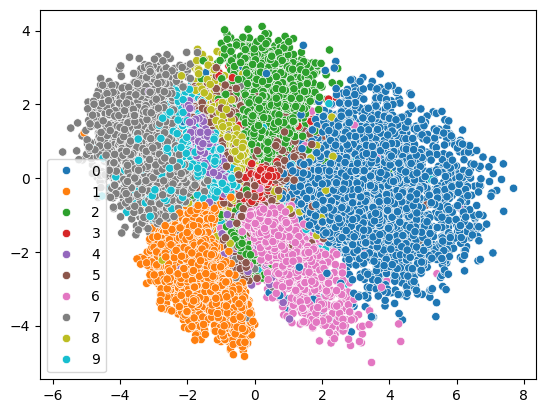

In [25]:
projected, labels = encode_batch(auto_encoder, test_data) 
sns.scatterplot(x=projected[:,0], y=projected[:,1], 
    hue=[str(l) for l in labels], 
    hue_order=[str(i) for i in range(10)], legend="full")


# 2\.  Train the bottleneck-style autoencoder with a target size D′ = 64 dimensions. Then use k-means (https://scikit-learn.org/stable/modules/clustering.html#k-means)to create k = 10 clusters on the original version of MNIST and the version encoded using D′ = 64 dimensions. Use the homogeneity score from scikit-learn (http://mng.bz/nYQV) to evaluate these clusters. Which method does best:k-means on the original images or k-means on the encoded representations?

## Train on original MNIST

In [56]:
train_data_xy = train_data
train_data_xx = AutoEncodeDataset(train_data)

test_data_xy = test_data
test_data_xx = AutoEncodeDataset(test_data)


train_loader = DataLoader(train_data_xx, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=256)

In [57]:
D_prime = 64
loss = nn.MSELoss()

auto_encoder_big = nn.Sequential( 
    nn.Flatten(), 
    getLayer(D, D_prime), 
    getLayer(D_prime, D_prime), 
    getLayer(D_prime, D_prime), 
    nn.Linear(D_prime, D_prime), 
)

auto_decoder_big = nn.Sequential( 
    getLayer(D_prime, D_prime), 
    getLayer(D_prime, D_prime), 
    getLayer(D_prime, D_prime), 
    nn.Linear(D_prime, D), 
    View(-1, 1, 28, 28) 
)

auto_encode_decode_big = nn.Sequential( 
    auto_encoder_big, 
    auto_decoder_big 
)

train_network(auto_encode_decode_big, loss, train_loader, 
 test_loader=test_loader, epochs=10, device=device)

Epoch: 100%|██████████| 10/10 [02:09<00:00, 12.95s/it]


,epoch,total time,train loss,test loss
0,0,8.212326,0.064511,0.043690
1,1,15.245774,0.039665,0.035692
2,2,22.502907,0.033854,0.031285
3,3,29.668031,0.030198,0.028266
4,4,39.162991,0.027800,0.026217
5,5,46.477483,0.025955,0.024602
6,6,53.789073,0.024593,0.023528
7,7,60.686199,0.023561,0.022489
8,8,67.412104,0.022597,0.021644
9,9,74.104910,0.021845,0.020829


## Use K-Means Clustering on untouched data, and the encoded data

In [58]:
from sklearn.cluster import KMeans

# K-Means expects 2 dimensional data
data_np = test_data_xx.dataset.data.numpy().reshape(-1, 28*28)

kmeans_baseline = KMeans(n_clusters=classes, random_state=0, n_init="auto").fit(data_np)
kmeans_baseline.labels_[:10]

array([2, 4, 9, 3, 7, 0, 3, 2, 3, 7], dtype=int32)

In [65]:
encoded_data, labels = encode_batch(auto_encoder_big, test_data_xy)

kmeans_encoded = KMeans(n_clusters=classes, random_state=0, n_init="auto").fit(encoded_data.reshape(len(encoded_data), -1))
kmeans_encoded.labels_[:10]

array([7, 4, 3, 8, 3, 0, 5, 7, 5, 6], dtype=int32)

In [60]:
# projected, labels = encode_batch(auto_encoder, test_data) 
# sns.scatterplot(x=projected[:,0], y=projected[:,1], 
#     hue=[str(l) for l in labels], 
#     hue_order=[str(i) for i in range(10)], legend="full")


## Use Homogeneity to evaluate both clusters

"This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way."

In [61]:
test_data_xx.dataset.targets


tensor([5, 0, 4,  ..., 5, 6, 8])

In [67]:
from sklearn import metrics

baseline_score = metrics.homogeneity_score(test_data_xx.dataset.targets, kmeans_baseline.labels_)
print(baseline_score)

encoded_score = metrics.homogeneity_score(test_data_xx.dataset.targets, kmeans_encoded.labels_)
print(encoded_score)

0.5277838234864394
0.47969147371294235


## Answer:

K-Means run against the raw images performs better than K-Means against encoded data. This make sense because the encodede data is not a perfect representation of the origianl data, and as a result, the K-Means model is training on partially lost data.

# 3\. Use the denoising approach to implement a denoising convolutional network. This can be done by not having any pooling operations so that the input stays the same size.

In [3]:
train_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)

In [115]:
def addNoise(x, device='cpu'): 
    """ 
    We will use this helper function to add noise to some data. 
    x: the data we want to add noise to 
    device: the CPU or GPU that the input is located on. 
    """ 
    
    normal = torch.distributions.Normal(0, 0.5)
    return x + normal.sample(sample_shape= torch.Size(x.shape)).to(device)

class AdditiveGaussNoise(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x): 
        if self.training:
            return addNoise(x, device=device) 
        else:
            return x

In [5]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256)

In [6]:
train_data[0][0].shape, train_data[0][1]

(torch.Size([1, 28, 28]), 5)

In [7]:
filters = 16
D = 28*28
n = 2
C = 1
classes = 10

loss = nn.CrossEntropyLoss()

In [10]:
def ConvLayer(c_in, c_out=None, filter_size=3):
   if c_out is None:
        c_out = c_in

   layer = nn.Sequential(
      nn.Conv2d(c_in, c_out, filter_size, padding=filter_size//2),
      nn.Tanh(),
   )

   return layer
      
model_cnn = nn.Sequential(
   AdditiveGaussNoise(),
   ConvLayer(C, filters),
   nn.Flatten(),
   nn.Linear(filters*D, classes),
)

results_model_cnn = train_network(model_cnn,
   loss, train_loader, test_loader=test_loader,
   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=4)

Epoch: 100%|██████████| 4/4 [00:51<00:00, 12.81s/it]


<Axes: xlabel='epoch', ylabel='test Accuracy'>

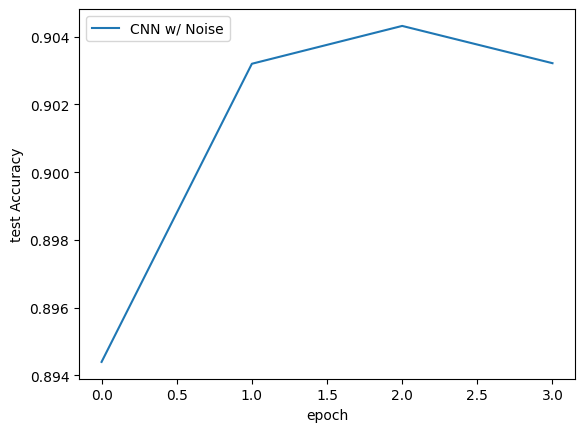

In [11]:
sns.lineplot(x='epoch', y='test Accuracy',
     data=results_model_cnn,
     label='CNN w/ Noise')

# 4\. Sometimes people train deep autoencoders with weight sharing between the encoder and decoder. Try implementing a deep bottleneck autoencoder that uses the `TransposeLinear` layer for all of the decoder’s layers. Compare the weight shared versus the non-weight shared network when you have only n = 1,024, 8,192, 32,768, and all 60,000 samples from MNIST.

In [12]:
train_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)

In [ ]:
train_data_xy = train_data
train_data_xx = AutoEncodeDataset(train_data)

test_data_xy = test_data
test_data_xx = AutoEncodeDataset(test_data)


train_loader = DataLoader(train_data_xx, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=256)

D = 28*28

In [14]:
class TransposeLinear(nn.Module):
    def __init__(self, linearLayer, bias=True):
        """ 
        linearLayer: is the layer that we want to use the transpose of to 
         produce the output of this layer. So the Linear layer represents 
         W, and this layer represents W^T. This is accomplished via 
         weight sharing by reusing the weights of linearLayer 
        bias: if True, we will create a new bias term b that is learned 
        separately from what is in 
        linearLayer. If false, we will not use any bias vector. 
        """ 

        super().__init__() 
        self.weight = linearLayer.weight

        if bias: 
            self.bias = nn.Parameter(torch.Tensor( 
             linearLayer.weight.shape[1]))

        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        return F.linear(x, self.weight.t(), self.bias)


In [ ]:
auto_encoder = nn.Sequential(
    nn.Flatten(), 
    getLayer(D, D//2),
    getLayer(D//2, D//3), 
    getLayer(D//3, D//4), 
    nn.Linear(D//4, n),
)

auto_decoder = nn.Sequential(
    getLayer(n, D//4),
    getLayer(D//4, D//3), 
    getLayer(D//3, D//2),

    nn.Linear(D//2, D), 
    View(-1, 1, 28, 28)
)
auto_encode_decode = nn.Sequential(
    auto_encoder, 
    auto_decoder 
)

In [101]:
# def getLayer(in_size, out_size): 
#     """ 
#     in_size: how many neurons/features are coming into this layer 
#     out_size: how many neurons/outputs this hidden layer should produce 
#     """ 
#     return nn.Sequential(
#         nn.Linear(in_size, out_size), 
#         nn.BatchNorm1d(out_size), 
#         nn.ReLU())

def create_bottle_neck_model(D, num_layers=1, weight_sharing=True):
    encoder = []
    decoder = []

    for i in range(1, num_layers + 1):
        if weight_sharing:
            linearLayer = nn.Linear(D//i, D//(i+1), bias=False)

            # Encoder
            if i == num_layers:
                encoder.append(nn.Linear(D//i, D//(i+1)))
            else:
                encoder.append(linearLayer)
                encoder.append(nn.BatchNorm1d(D//(i+1)))
                encoder.append(nn.ReLU())
            
            # Decoder
            if i == 1:
                decoder.insert(0, TransposeLinear(linearLayer, bias=False))
            else:
                decoder.insert(0, nn.ReLU())
                decoder.insert(0, nn.BatchNorm1d(D//i))
                decoder.insert(0, TransposeLinear(linearLayer, bias=False))

        else:
            # Encoder
            if i == num_layers:
                encoder.append(nn.Linear(D//i, D//(i+1)))
            else:
                encoder.append(getLayer(D//i, D//(i+1)))
            
            # Decoder
            if i == 1:
                decoder.insert(0, nn.Linear(D//(i+1), D//i))
            else:
                decoder.insert(0, getLayer(D//(i+1), D//i))



    encoder.insert(0, nn.Flatten())
    decoder.append(View(-1, 1, 28, 28))

    encoder = nn.Sequential(*encoder)
    decoder = nn.Sequential(*decoder)

    return encoder, decoder

In [102]:
model = create_bottle_neck_model(D, num_layers=3, weight_sharing=True)
print(model)

(Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=392, bias=False)
  (2): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=392, out_features=261, bias=False)
  (5): BatchNorm1d(261, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=261, out_features=196, bias=True)
), Sequential(
  (0): TransposeLinear()
  (1): BatchNorm1d(261, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): TransposeLinear()
  (4): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): TransposeLinear()
  (7): View()
))


In [83]:
loss = nn.MSELoss()

encoder, decoder = create_bottle_neck_model(D, 4, weight_sharing=False)

model = nn.Sequential( 
    encoder, 
    decoder 
)

train_network(model, loss, train_loader, 
 test_loader=test_loader, epochs=10, device=device)

Epoch: 100%|██████████| 10/10 [02:02<00:00, 12.29s/it]


,epoch,total time,train loss,test loss
0,0,6.842631,0.038122,0.023414
1,1,13.434773,0.020722,0.017484
2,2,20.211350,0.016827,0.015224
3,3,26.811974,0.014827,0.013506
4,4,33.458363,0.013479,0.012182
5,5,40.282900,0.012527,0.011643
6,6,47.212395,0.011765,0.011115
7,7,54.638146,0.011156,0.010192
8,8,62.018980,0.010672,0.009765
9,9,69.454505,0.010303,0.009590


[]

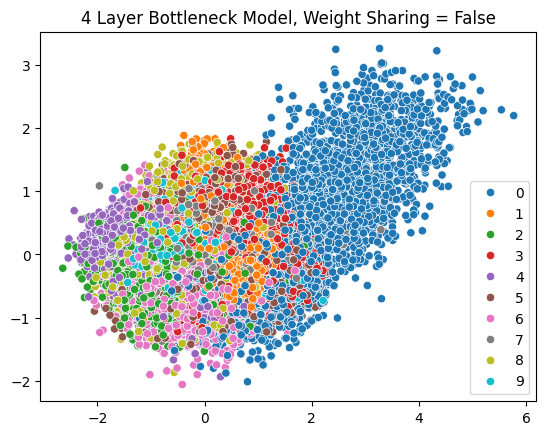

In [ ]:
projected, labels = encode_batch(encoder, test_data_xy) 
sns.scatterplot(x=projected[:,0], y=projected[:,1], 
    hue=[str(l) for l in labels], 
    hue_order=[str(i) for i in range(10)], legend="full")
plt.title("4 Layer Bottleneck Model, Weight Sharing = False")
plt.plot()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [02:04<00:00, 12.45s/it]


[]

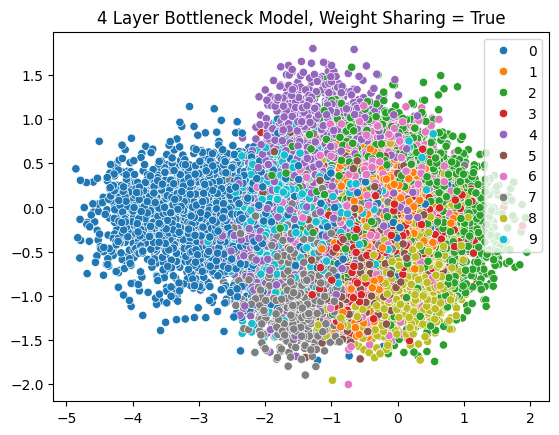

In [103]:
loss = nn.MSELoss()

encoder, decoder = create_bottle_neck_model(D, 4, weight_sharing=True)

model = nn.Sequential( 
    encoder, 
    decoder 
)

train_network(model, loss, train_loader, 
 test_loader=test_loader, epochs=10, device=device)

projected, labels = encode_batch(encoder, test_data_xy) 
sns.scatterplot(x=projected[:,0], y=projected[:,1], 
    hue=[str(l) for l in labels], 
    hue_order=[str(i) for i in range(10)], legend="full")
plt.title("4 Layer Bottleneck Model, Weight Sharing = True")
plt.plot()

## Compare the weight shared versus the non-weight shared network when you have only n = 1,024, 8,192, 32,768, and all 60,000 samples from MNIST.

In [93]:
len(Subset(train_data, range(1024)))

1024

In [104]:
f"{True}"

'True'

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 100%|██████████| 6/6 [00:34<00:00,  5.76s/it]


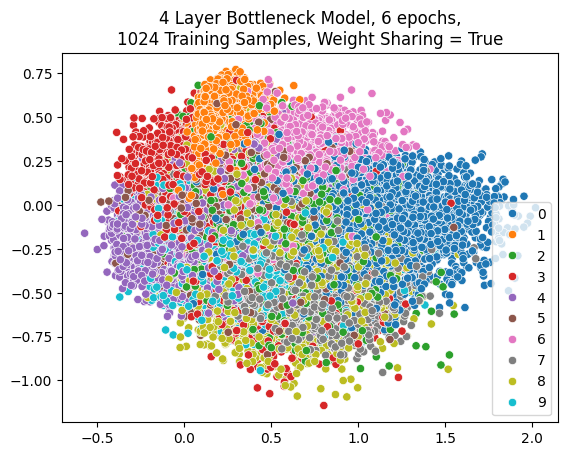

Epoch: 100%|██████████| 6/6 [00:36<00:00,  6.06s/it]


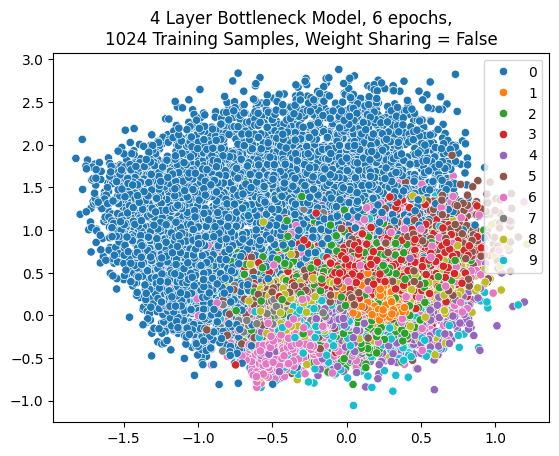

Epoch: 100%|██████████| 6/6 [00:39<00:00,  6.57s/it]


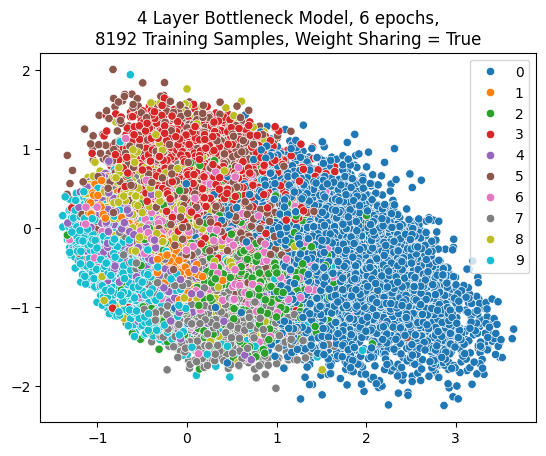

Epoch: 100%|██████████| 6/6 [00:40<00:00,  6.72s/it]


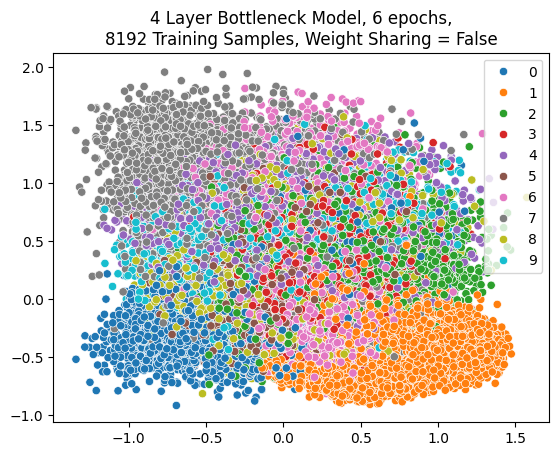

Epoch: 100%|██████████| 6/6 [00:53<00:00,  8.88s/it]


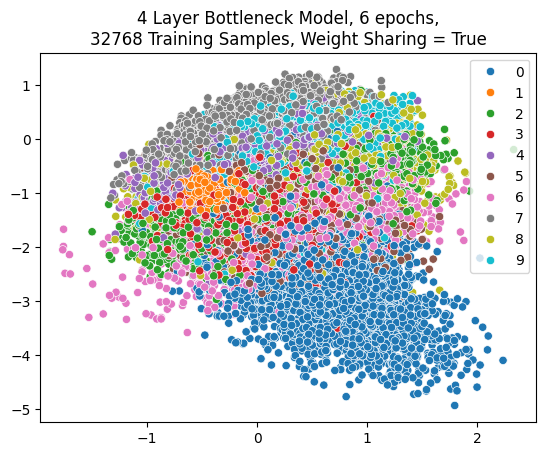

Epoch: 100%|██████████| 6/6 [00:53<00:00,  8.94s/it]


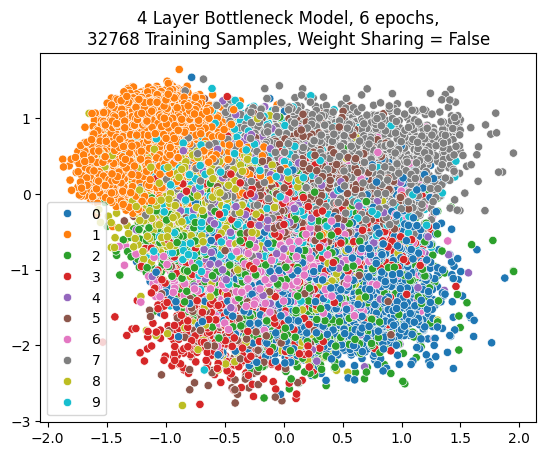

Epoch: 100%|██████████| 6/6 [01:17<00:00, 12.92s/it]


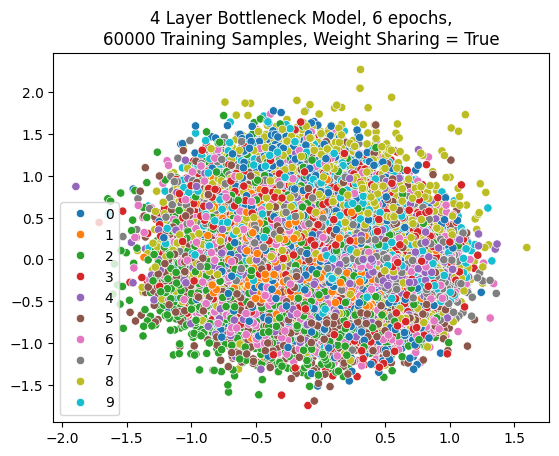

Epoch: 100%|██████████| 6/6 [01:14<00:00, 12.49s/it]


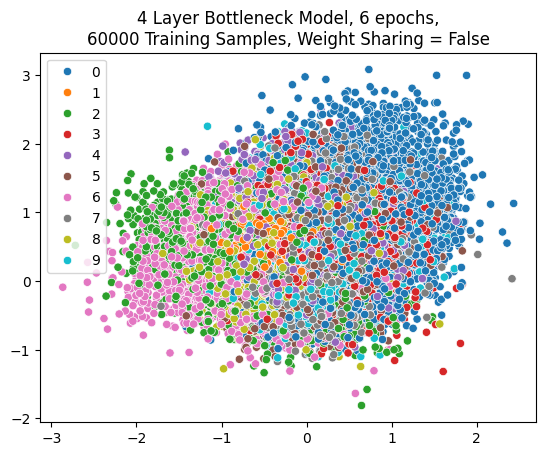

In [110]:
epochs = 6
results = {}

for n_samples in [1024, 8192, 32768, 60000]:
# for n_samples in [60000]:
    # Data Loader stuff
    train_data_xy = Subset(train_data, range(n_samples))
    train_data_xx = AutoEncodeDataset(Subset(train_data, range(n_samples)))

    test_data_xy = test_data
    test_data_xx = AutoEncodeDataset(test_data)

    train_loader = DataLoader(train_data_xx, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_data_xx, batch_size=256)

    
    for weight_sharing in [True, False]:
        # Define Model
        encoder, decoder = create_bottle_neck_model(D, 3, weight_sharing=weight_sharing)
        model = nn.Sequential( 
            encoder, 
            decoder 
        )

        # Train
        train_network(model, loss, train_loader, test_loader=test_loader, epochs=epochs, device=device)

        # Saving into dict for later comparison
        model_details = {}
        model_details["encoder"] = encoder
        model_details["decoder"] = decoder

        results[f"n_samples_{n_samples}_ws_{weight_sharing}"] = model_details

        # Plotting
        projected, labels = encode_batch(encoder, test_data_xy) 
        sns.scatterplot(x=projected[:,0], y=projected[:,1], 
            hue=[str(l) for l in labels], 
            hue_order=[str(i) for i in range(10)], legend="full")
        plt.title(f"4 Layer Bottleneck Model, {epochs} epochs,\n{n_samples} Training Samples, Weight Sharing = {weight_sharing}")
        plt.show()



# 5\. **Challenging:** Train an asymmetric denoising autoencoder for MNIST where the encoder is a fully connected network and the decoder is a convolutional network. 

## Hint: You will need to end the encoder with a `View` layer that changes the shape from (B, D) to (B, C,28,28), where D is the number of neurons in the last `nn.LinearLayer` of the encoder and D = C ⋅ 28 ⋅ 28. 

## Do the results of this network look better or worse than the fully connected network in the chapter, and how do you think intermixing architectures impacts that result?

In [6]:
train_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)

In [14]:
def addNoise(x, device='cpu'): 
    """ 
    We will use this helper function to add noise to some data. 
    x: the data we want to add noise to 
    device: the CPU or GPU that the input is located on. 
    """ 
    
    normal = torch.distributions.Normal(0, 0.5)
    return x + normal.sample(sample_shape= torch.Size(x.shape)).to(device)

class AdditiveGaussNoise(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x): 
        if self.training:
            return addNoise(x, device=device) 
        else:
            return x

In [10]:
class AutoEncodeDataset(Dataset): 
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to reuse other code"""

    def __init__(self, dataset): 
        self.dataset = dataset

    def __len__(self): 
        return len(self.dataset)

    def __getitem__(self, idx): 
        x, y = self.dataset.__getitem__(idx) 
        return x, x

In [11]:
train_data_xy = train_data
train_data_xx = AutoEncodeDataset(train_data)

test_data_xy = test_data
test_data_xx = AutoEncodeDataset(test_data)


train_loader = DataLoader(train_data_xx, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=256)

D = 28*28
C = 1

In [12]:
def ConvLayer(c_in, c_out=None, filter_size=3):
   if c_out is None:
        c_out = c_in

   layer = nn.Sequential(
      nn.Conv2d(c_in, c_out, filter_size, padding=filter_size//2),
      nn.Tanh(),
   )

   return layer

In [18]:
# The encoder is a fully connected network
auto_encoder = nn.Sequential(
    nn.Flatten(), 
    # getLayer(D, D//2),
    # getLayer(D//2, D//3), 
    # getLayer(D//3, D//4), 
    nn.Linear(D, D),
)

# The decoder is a convolutional network
auto_decoder = nn.Sequential(
)

model = nn.Sequential(
    AdditiveGaussNoise(),
    auto_encoder, 
    auto_decoder 
)
      

loss = nn.MSELoss()

results_model_cnn = train_network(model,
   loss, train_loader, test_loader=test_loader,
   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=4)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]C:\Users\miles\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([256, 1, 28, 28])) that is different to the input size (torch.Size([256, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (784) must match the size of tensor b (28) at non-singleton dimension 3

# 6\. Challenging: Reshape the MNIST dataset as a sequence of pixels, and train an autoregressive model over the pixels. This requires using real-valued inputs and outputs, so you will not use an nn.Embedding layer, and you will need to switch to the MSE loss function. After training, try generating multiple digits from this autoregressive pixel model.

In [3]:
train_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)

In [4]:
len(train_data)

60000

In [22]:
class AutoRegressiveMNISTDataset(Dataset): 
    """ 
    Creates an autoregressive dataset from MNIST input
    TODO:
        - Reshape the MNIST dataset as a sequence of pixels   
    """

    def __init__(self, dataset, num_images=None, max_chunk=26): 
        """ 
        large_string: the original long source sequence that chunks will 
         be extracted from 
        max_chunk: the maximum allowed size of any chunk. 
        """
        self.max_chunk = max_chunk

        # Starting with the "dumb" logic of flattening everything
        self.data = []

        
        count = 0
        for X, y in dataset:
            # Reshape the MNIST dataset as a sequence of pixels
            # self.data.append(X.view(-1))
            X_flat = X.view(-1)
            for pixel in X_flat:
                self.data.append(pixel)

            if num_images is not None:
               count +=1
               if count >= num_images:
                   break


    def __len__(self): 
        return (len(self.data)) // self.max_chunk

    def __getitem__(self, idx): 
        start = idx*self.max_chunk

        x = self.data[start:start+self.max_chunk]
        y = self.data[start+1:start+self.max_chunk+1]
        x = [int(elem) for elem in x]
        y = [int(elem) for elem in y]
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, 
         dtype=torch.int64)

In [23]:
class AutoRegressive(nn.Module):

    def __init__(self, max_chunk, output_size, hidden_size, layers=1):
       super(AutoRegressive, self).__init__() 

       self.hidden_size = hidden_size 

       self.layers = nn.ModuleList(
            [nn.GRUCell(max_chunk, hidden_size)] + [nn.GRUCell(hidden_size, hidden_size) 
            for i in range(layers-1)])
       self.norms = nn.ModuleList( 
            [nn.LayerNorm(hidden_size) for i in range(layers)])
       
       self.pred_class = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(), 
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, input):
        B = input.size(0)
        T = input.size(1)

        x = input

        h_prevs = self.initHiddenStates(B)

        last_activations = [] 
        for t in range(T):
            x_in = x[:,t,:]
            last_activations.append(self.step(x_in, h_prevs))

        last_activations = torch.stack(last_activations, dim=1)

        return last_activations
    
    def initHiddenStates(self, B): 
        """ 
        Creates an initial hidden state list for the RNN layers.

        B: the batch size for the hidden states. 
        """ 
        return [torch.zeros(B, self.hidden_size, device=device) 
            for _ in range(len(self.layers))]
    
    def step(self, x_in, h_prevs=None): 
        """ 
        x_in: the input for this current time step and has shape (B) 
        if the values need to be embedded, and (B, D) if they 
        have already been embedded.

        h_prevs: a list of hidden state tensors each with shape 
        (B, self.hidden_size) for each layer in the network.
        These contain the current hidden state of the RNN layers 
        and will be updated by this call. 
        """

        if len(x_in.shape) == 1:
            x_in = self.embd(x_in)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])

        for l in range(len(self.layers)):
            h_prev = h_prevs[l] 
            h = self.norms[l](self.layers[l](x_in, h_prev))

            h_prevs[l] = h 
            x_in = h 
        return self.pred_class(x_in)
    
    

In [24]:
def applyLinearLayerOverTime(x): 
    results = []
    B, T, D = x.shape 
    for t in range(T): 
        results.append(linearLayer(x[:,t,:]))
        
    return torch.stack(results, dim=0).view(B, T, -1)

In [25]:
max_chunk = 25

autoRegData = AutoRegressiveMNISTDataset(train_data, num_images=1000, max_chunk=max_chunk) 
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

In [37]:
len(autoRegData[140][0])

25

In [27]:
autoReg_model = AutoRegressive(max_chunk, 1, 128, layers=1) 
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters(): 
   p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [28]:
def CrossEntLossTime(x, y): 
    """ 
    x: output with shape (B, T, V) 
    y: labels with shape (B, T) 
    """ 
    cel = nn.CrossEntropyLoss() 

    T = x.size(1) 

    loss = 0 

    for t in range(T):
        loss += cel(x[:,t,:], y[:,t])

    return loss

def MSELossTime(x, y): 
    """ 
    x: output with shape (B, T, V) 
    y: labels with shape (B, T) 
    """ 
    cel = nn.MSELoss() 

    T = x.size(1) 

    loss = 0 

    for t in range(T):
        loss += cel(x[:,t,:], y[:,t])

    return loss

In [29]:
train_network(autoReg_model, MSELossTime, autoReg_loader, epochs=2, 
 device=device)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]
c:\Users\miles\Dev\InsideDeepLearningExercises\../Inside-Deep-Learning\idlmam.py:215: SyntaxWarning: invalid escape sequence '\e'
  """Train simple neural networks


IndexError: too many indices for tensor of dimension 2